# Cross-validation in general 

https://scikit-learn.org/stable/modules/cross_validation.html

Parameter estimation using grid search with cross-validation: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py

https://scikit-learn.org/stable/modules/grid_search.html#grid-search

https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py

# Cross-validation in time series

Hyper-paramatering tuning like grid search or random search use a cross validation method where data is split into k groups. There are k trainings where k-1 samples are used in training in 1 in testing. The results are averaged out and the best model is chosen. But then only in 1 of the cases the test sample is at the end, following the natural course of learning from the past to predict the future. In the other k-1 cases, you would use some data from the future to predict the past. 

# Method 1

A method 1 is to divide the data and steps like this. Note that if we divide in k folds, there are k-1 steps. The algorithm is also implemented with a code in a blog post [Pythonic Cross Validation on Time Series](http://francescopochetti.com/pythonic-cross-validation-time-series-pandas-scikit-learn/). The algorithm is shown below:
1. train [1], test [2]
2. train [1, 2], test [3]
3. train [1, 2, 3], test [4]
4. train [1, 2, 3, 4], test [5]

This has the particularity that each new step uses more data and is expected to perfom better than the previous one. So when calculating the total figure of merit, it is best to not use the regular average, but an weighted average by how many datasets were used in the train sample, so thatmetric_average = (1 * m1 + 2 * m2 + 3 * m3 + 4 * m4)/(1+2+3+4).

# Method 2

Another method 2 is to divide the steps to use equal amounts of data. It is still good to train in more data than the test. Here the regular average and the weighted average give the same result. Note that if we divide in k folders, we have k-2 steps. The algorithms is:
1. train [1, 2], test [3]
2. train [2, 3], test [4]
3. train [3, 4], test [5]

# Method 3

Another method 3 presented in this great [blog summary on robjhyndman.com](https://robjhyndman.com/hyndsight/crossvalidation/), inspired from a paper from 2010 on [A survey of cross-validation procedures for model selection](https://projecteuclid.org/euclid.ssu/1268143839). The method is the leave one out cross validation (LOOCV) adapted for the time series. The result is that of solution 1, where the time interval that forms a dataset is the minimum possible. If the observations are discrete it is one observation at a time. If the consistent time interval with counts is one hour across a year, than one interval is just a one hour interval. This is of course expected to take more time than just using method 1 with 10 folds.

1. Train sample contains the data y_1, y_2, ..., y_t, where the index is the time moment or the time bin. The test sample is formed only from one data pint y_(t+1). Computed the error, sometimes called the predicted residual, e*_i = (y_i -y^hat_i), where y^hat_i is the predicted value by our model for the time moment i, and y_i is the true value (target, label) for the time i. 
2. Repeat the step 1 for all t from m to n-1, where m is the minimum number of observations needed to fit a model and n is the total amount of observations or time intervals in our data.
3. Compute the MSE from e*_(m+1) to e*_n with the formula MSE = [1/(n-m)]*(y_i - y^hat_i)^2.


# Give manual splittings to sklearn

We can code by hand the splitting according to these algorithms, then give the list of tuple of datasets to [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), a This defines the `cv` object used by `GridSearchCV`. It seems the same `cv` can be given also to [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Example from s in this [StackOverflow](https://stackoverflow.com/questions/37583263/scikit-learn-cross-validation-custom-splits-for-time-series-data):

```
[
 (split1_train_idxs, split1_test_idxs),
 (split2_train_idxs, split2_test_idxs),
 (split3_train_idxs, split3_test_idxs),
 ...
]
```
for example
```
groups = df.groupby(df.date.dt.year).groups
# {2012: [0, 1], 2013: [2], 2014: [3], 2015: [4, 5]}
sorted_groups = [value for (key, value) in sorted(groups.items())] 
# [[0, 1], [2], [3], [4, 5]]

cv = [(sorted_groups[i] + sorted_groups[i+1], sorted_groups[i+2])
      for i in range(len(sorted_groups)-2)]
```
This looks like this
```
[([0, 1, 2], [3]),  # idxs of first split as (train, test) tuple
 ([2, 3], [4, 5])]  # idxs of second split as (train, test) tuple
```
Then you can do grid search with
```
GridSearchCV(estimator, param_grid, cv=cv, ...)
```
or
```
RandomizedSearchCV(estimator, param_grid, cv=cv, ...)
```

# Calculate splittings automatically in sklearn

We can calculate the splittings for Method 1 automatically in sklearn using [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit). Example of code in blog [Time Series Nested Cross-Validation with scikit-learn](https://www.angioi.com/time-nested-cv-with-sklearn/) and below in page.

A genearalisation of the TimeSeriesSplit is the [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html#sklearn.model_selection.GroupShuffleSplit).

# Visualising CV split

https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py

# Resources 

Hints taken from [StackOverflow](https://stats.stackexchange.com/questions/117350/how-to-split-dataset-for-time-series-prediction/412476#412476):
* Split into smaller datasets and check for parameter stability over time; if can be divided into geographical region, check also in those regions. I interpret it as check in subsets of the data, not just the averages across the entire data sample.
* Akaike Information Criterion (AIC) for time series. One period ahead forcast error. 
* ARIMA would be for a dynamic model

http://francescopochetti.com/pythonic-cross-validation-time-series-pandas-scikit-learn/

https://robjhyndman.com/hyndsight/crossvalidation/

# Example code for TimeSeriesSplit

Taken from https://www.angioi.com/time-nested-cv-with-sklearn/

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [82]:
# generate a data frame to simulate two columns of random numbers for each day of a year
nRows = 365
df = pd.DataFrame(np.random.randint(0, 5, size=(nRows, 1)), 
                  columns = ["x1"], 
                  index = pd.date_range("20180101", periods=nRows))
df

,x1
2018-01-01,1
2018-01-02,3
2018-01-03,3
2018-01-04,4
2018-01-05,1
...,...
2018-12-27,2
2018-12-28,1
2018-12-29,0
2018-12-30,0


In [83]:
# add y as the sum of the x1 + x2 + some noise from a gauss distribution of mu=0 and sigma = 1
mu = 0.0
sigma = 1.0
df["x1"] = df.apply(lambda row: row["x1"] + random.gauss(mu, sigma), axis = 1)
df["y"] = df.apply(lambda row: row["x1"] + random.gauss(mu, sigma), axis = 1)
df

,x1,y
2018-01-01,1.959761,2.301392
2018-01-02,3.710959,3.018888
2018-01-03,1.064980,1.868981
2018-01-04,2.418963,2.452304
2018-01-05,-0.505510,1.347748
...,...,...
2018-12-27,2.574924,3.082455
2018-12-28,1.938405,2.323465
2018-12-29,-1.722473,-2.039858
2018-12-30,-1.985575,-0.833723


In [84]:
# to plot only the first 3 rows
with pd.option_context("display.max_rows", 6):
    print(df)

                  x1         y
2018-01-01  1.959761  2.301392
2018-01-02  3.710959  3.018888
2018-01-03  1.064980  1.868981
...              ...       ...
2018-12-29 -1.722473 -2.039858
2018-12-30 -1.985575 -0.833723
2018-12-31  3.288063  4.099696

[365 rows x 2 columns]


In [85]:
# we want to prepare the nested cross validation for time series
from sklearn.model_selection import TimeSeriesSplit
n_splits = 3 # Number of train/cv/test folds

In [86]:
trainTestSplit = TimeSeriesSplit(n_splits + 1).split(df)
trainTestSplit

<generator object TimeSeriesSplit.split at 0x11b644350>

In [87]:
# Skip the first fold
# each trainTestSplit is a tuple of two arrays, one for train, one for test
# one unit is 73 days, as 73*5 = 365
# first has train first 73, test next 73
next(trainTestSplit) 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72]),
 array([ 73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
         86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
        125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
        138, 139, 140, 141, 142, 143, 144, 145]))

In [88]:
# second has train first 73 * 2, test next 73
next(trainTestSplit) 

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145]),
 array([146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
        159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
        172, 173, 174, 175

In [89]:
# third has train first 73 * 4, test next 73
next(trainTestSplit) 

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [90]:
# fourth has train first 73 * 3, test next 73
# and that completes all the possibilities
# we ended up with the test dataset on the same number of days as the others as 73*5=365.
next(trainTestSplit) 

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [91]:
# use .iloc to retrieve elements from the original df using the index as integers
# and not the the data from the time series
# and let's reinitialize the iterators
trainTestSplit = TimeSeriesSplit(n_splits + 1).split(df)
# skip the first fold
next(trainTestSplit) 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72]),
 array([ 73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
         86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
        125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
        138, 139, 140, 141, 142, 143, 144, 145]))

In [92]:
# 0 is the first column for X
# 1 is the second column for y
trainCvSplit = []
for trainCvIndices, testIndices in trainTestSplit:
    # first, we split Train + CV and Test
    X_train_CV, y_train_CV = df.iloc[trainCvIndices, 0], df.iloc[trainCvIndices, 1]
    X_test, y_test = df.iloc[testIndices, 0], df.iloc[testIndices, 1]
    
    # now split Train + CV into Train and CV separately, by having CV of same length as the Test
    testLength = len(X_test)
    trainCvSplit.append(
        (
            list(range(trainCvIndices[0], trainCvIndices[-testLength])), # Train
            list(range(trainCvIndices[-testLength], trainCvIndices[-1]+1)), # CV
        )
    )
    
    # Printing date ranges
    print("Training:"           , X_train_CV.index[0].date(), "--", X_train_CV.index[-testLength-1].date(),
          ", CV:"     , X_train_CV.index[-testLength].date(), "--", X_train_CV.index[-1].date(),
          ", Test:"                , X_test.index[0].date(), "--", X_test.index[-1].date())


Training: 2018-01-01 -- 2018-03-14 , CV: 2018-03-15 -- 2018-05-26 , Test: 2018-05-27 -- 2018-08-07
Training: 2018-01-01 -- 2018-05-26 , CV: 2018-05-27 -- 2018-08-07 , Test: 2018-08-08 -- 2018-10-19
Training: 2018-01-01 -- 2018-08-07 , CV: 2018-08-08 -- 2018-10-19 , Test: 2018-10-20 -- 2018-12-31


In [93]:
# the trainCvSplit can be passed directly as a cv argument
len(trainCvSplit)

3

In [94]:
X = df.iloc[:, [0]]
X

,x1
2018-01-01,1.959761
2018-01-02,3.710959
2018-01-03,1.064980
2018-01-04,2.418963
2018-01-05,-0.505510
...,...
2018-12-27,2.574924
2018-12-28,1.938405
2018-12-29,-1.722473
2018-12-30,-1.985575


In [95]:
y = df.iloc[:, -1]
y

2018-01-01    2.301392
2018-01-02    3.018888
2018-01-03    1.868981
2018-01-04    2.452304
2018-01-05    1.347748
                ...   
2018-12-27    3.082455
2018-12-28    2.323465
2018-12-29   -2.039858
2018-12-30   -0.833723
2018-12-31    4.099696
Freq: D, Name: y, Length: 365, dtype: float64

In [96]:
# perform a lasso regression with iterative fitting along a regularisation path
# the best model is selected by cross validation
from sklearn.linear_model import LassoCV
modelCV = LassoCV(cv = trainCvSplit).fit(X, y)

In [97]:
# score
modelCV.score(X, y)

0.7351530828154118

In [98]:
# make predictions
y_pred = modelCV.predict(X)
y_pred

array([ 1.92264628e+00,  3.62249167e+00,  1.05410477e+00,  2.36838270e+00,
       -4.70331968e-01, -9.68791452e-01,  4.00570485e+00,  3.35478229e+00,
       -7.43333466e-01,  3.65290785e+00,  8.40207537e-01,  3.57007864e+00,
        3.00904574e+00,  2.96409046e+00,  8.62939178e-02,  3.19621751e+00,
        1.22588836e+00,  1.70125113e+00, -4.85265488e-01, -9.75710785e-01,
        5.40267267e+00,  2.55388312e+00,  3.60559814e+00,  2.10402068e+00,
        4.68294064e+00, -1.14923127e+00,  1.19299734e+00, -8.22021258e-01,
        9.23694802e-01,  2.94379369e+00,  4.45692563e+00,  1.40723468e+00,
       -5.62522872e-01,  2.55252900e+00, -1.00151334e+00,  3.03105958e+00,
        3.51951260e+00,  1.48071308e-01,  1.41284471e+00,  1.88843697e+00,
        2.41321953e+00,  1.53403997e+00,  4.15755574e+00,  1.70521785e+00,
        3.98761477e+00,  1.99201153e+00, -7.24231369e-01,  3.20375408e+00,
        8.34366174e-01,  1.11470658e+00,  1.07077761e+00, -9.87792206e-01,
        2.14537381e+00,  

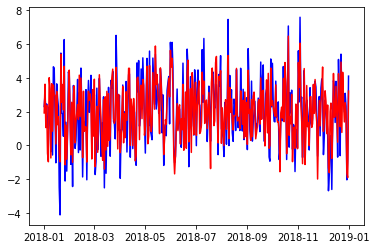

In [99]:
plt.plot(df.index, df.y, color = "blue", label = "y_true")
plt.plot(df.index, y_pred, color = "red", label = "y_predicted")

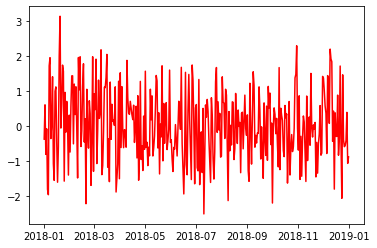

In [100]:
plt.plot(df.index, y_pred - df.y, color = "red", label = "y_true_predicted")

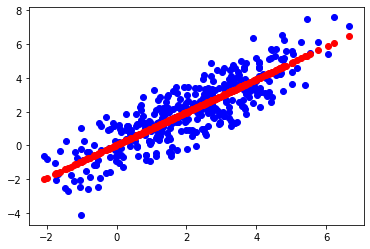

In [101]:
plt.scatter(df.x1, df.y, color = "blue", label = "y_true")
plt.scatter(df.x1, y_pred, color = "red", label = "y_predicted")

# Other

In [105]:
import scipy
scipy.stats.expon(scale=100)